## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format

TODO:
- Compute correlation instead of covariance => NO, we will use information;
- Compute covariance matrix (4x4) with averaging on each quadrant;


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
# import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### PARAMS
PARAMS = {'save_figs': True    
         }

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
save_dir = '/home/arthur/results/bigData2022_covariance/v4/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [3]:
### PLOTTING WIND FIELDS 
# Print the first TC of the Dataset
### OUTLIERS: i= 3, 4, 5
# du.plot_wind_field(ds_all, time_idx=5)

# Print all the TCs named 'HECTOR'
# storm_name = 'HECTOR'
# print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
# for time_idx in find_time_idx(ds_all, storm_name):
#     plot_wind_field(ds_all, time_idx)

In [4]:
### CONVERT TO POLAR R* GRID AND CONCATENATE
listOfDatasets  = []
r_ref_ax        = du.create_reference_axis(size=16, interval=0.25)
th_ref_ax       = du.create_reference_axis(size=360, interval=5)
crop_thresh     = 300000

n_total = len(ds_all['time'])
n_test  = 5
n       = n_total
ds_all  = ds_all.isel(time=slice(0, n))

### PREPARATION OF THE DATASET
# Filter
ds_all = du.filter_out_whole_dataset(ds_all)
# Crop
# ds_all = ds_all.sel(x=slice(-crop_thresh, crop_thresh), y=slice(-crop_thresh, crop_thresh))
# Eventually save 
# du.save_all_wind_fields(ds_all, save_dir='/home/arthur/results/bigData2022_covariance/341_files_rotated_cartesian_filtered/')

### CONVERT TO POLAR
print('Converting to polar coordinates...')
for time_idx in tqdm(range(n)):
    ds_polar  = du.get_ds_in_polar_r_star_coords_v03(ds_all, time_idx, r_ref_ax, th_ref_ax)
    listOfDatasets.append(ds_polar)
ds_polar_all = xr.concat(listOfDatasets, dim='time')

Filtering wind speed pixel outliers...


100%|█████████████████████████████████████████| 341/341 [01:12<00:00,  4.72it/s]


Converting to polar coordinates...


100%|█████████████████████████████████████████| 341/341 [03:34<00:00,  1.59it/s]


In [5]:
### SAVE DATASET
# ds_polar_all.to_netcdf('/home/arthur/results/bigData2022_covariance/ds_polar_all.nc')
### LOAD DATASET IF PRESENT
ds_polar_all = xr.open_dataset('/home/arthur/results/bigData2022_covariance/ds_polar_all.nc')

In [6]:
for cat, ds_cat in ds_polar_all.groupby('cat'):   
    ### MEAN
    ax    = plt.subplot(projection = "polar")
    plt.title('Cat. %i'%cat + '\n%i TCs'%ds_cat.dims['time'], weight='bold')
    mean  = ds_cat.mean('time', skipna=True)['wind_speed']
    r, th = np.meshgrid(mean['r*'], mean['th'])
    plt.pcolormesh(np.deg2rad(th), r, mean);plt.colorbar();plt.grid() # Put theta in radians!! 
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    plt.savefig(save_dir + 'mean_cat%i'%cat) if PARAMS['save_figs'] else plt.show()
    plt.clf()
    
    ### STD    
    ax    = plt.subplot(projection = "polar")
    std   = ds_cat.std('time', skipna=True)['wind_speed']
    r, th = np.meshgrid(std['r*'], std['th'])
    plt.pcolormesh(np.deg2rad(th), r, std);plt.colorbar();plt.grid() # Put theta in radians!! 
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    plt.savefig(save_dir + 'std_cat%i'%cat) if PARAMS['save_figs'] else plt.show()
    plt.clf()

<Figure size 1080x720 with 0 Axes>

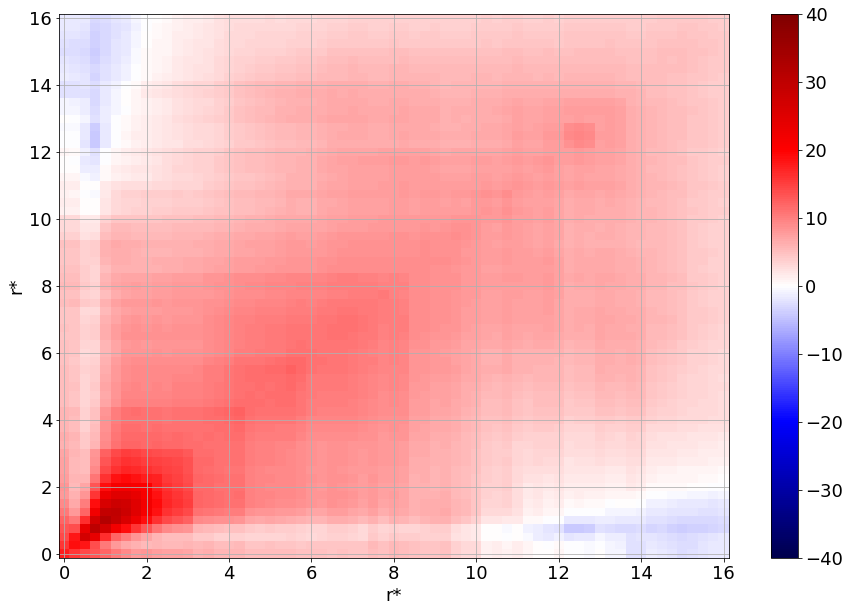

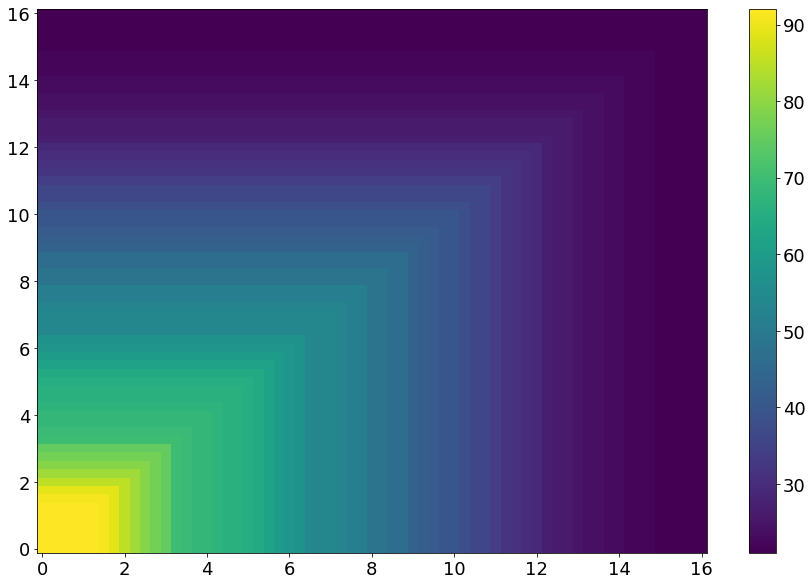

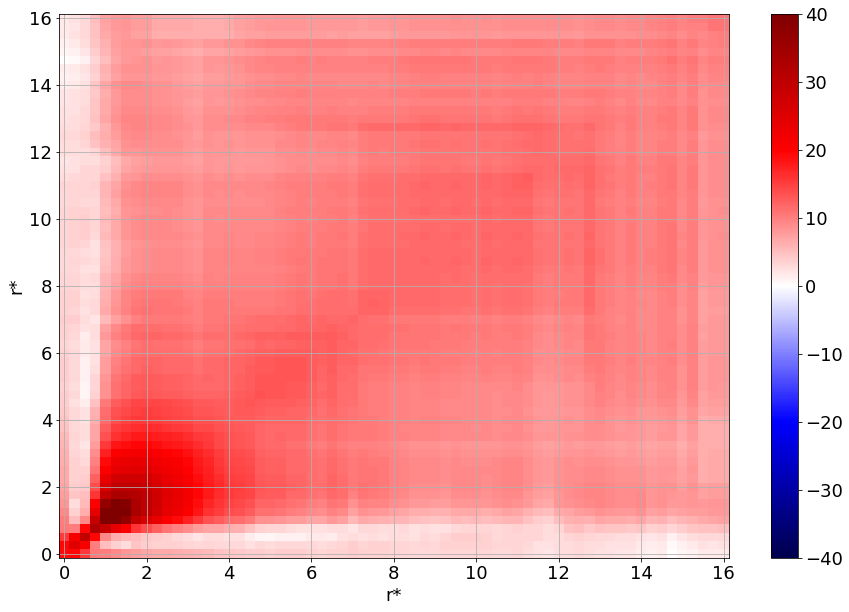

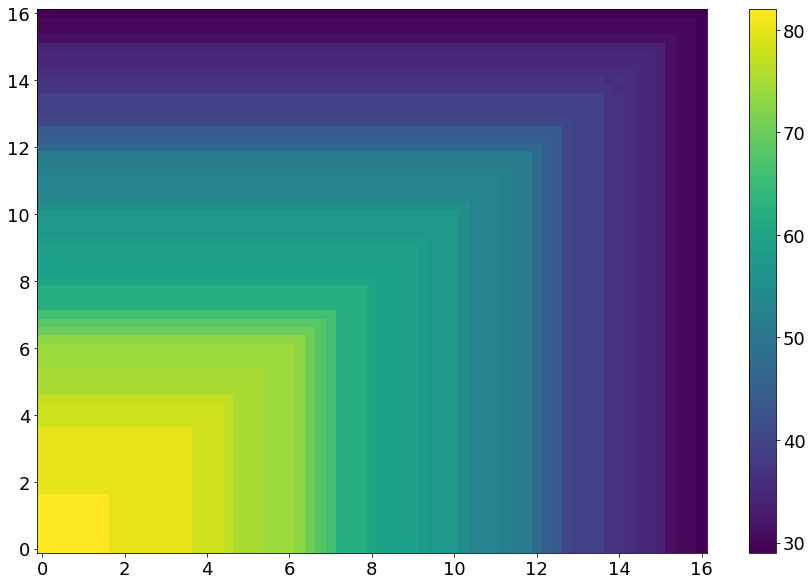

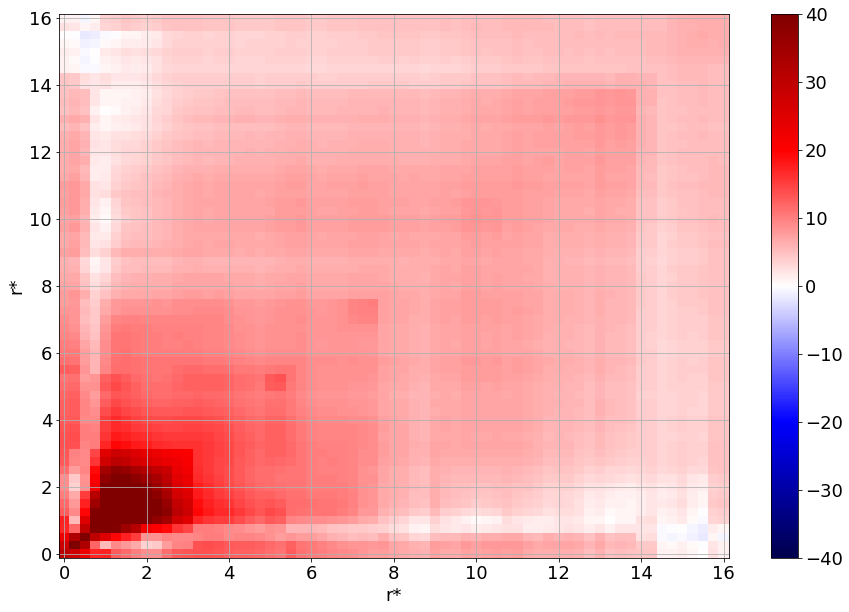

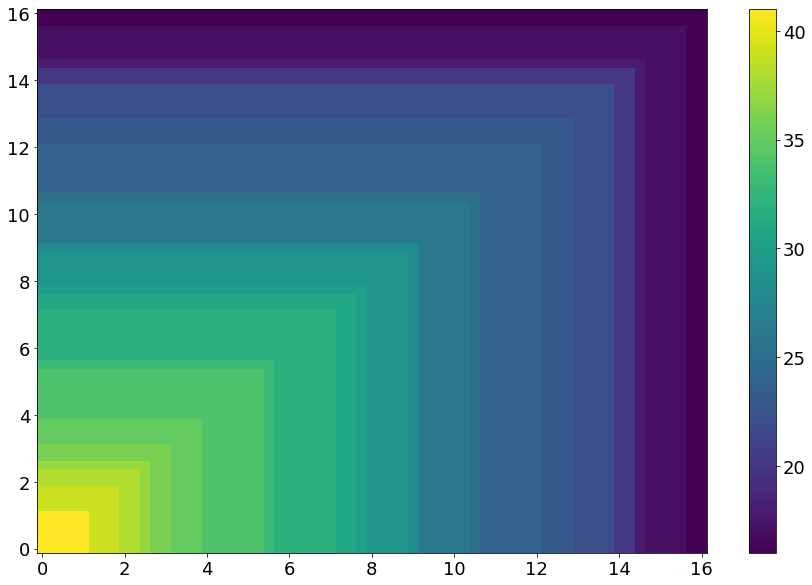

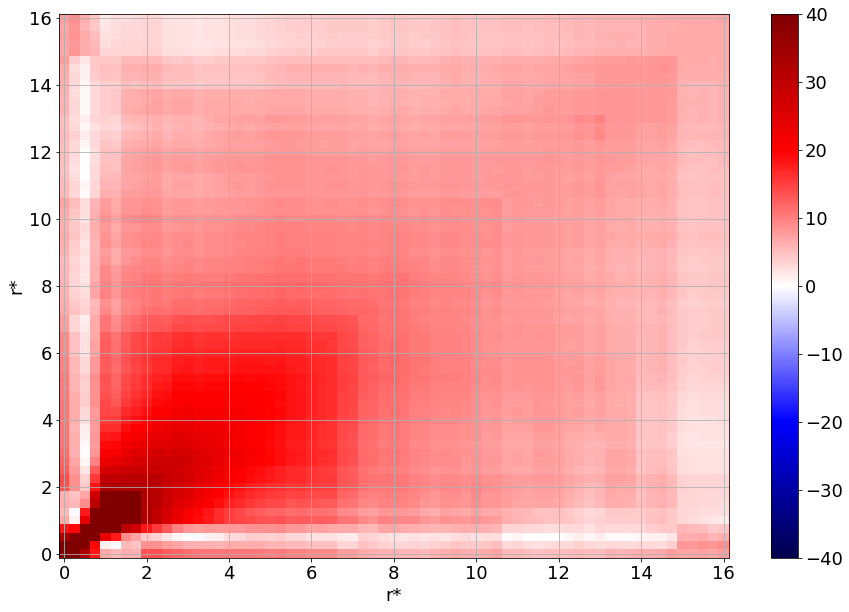

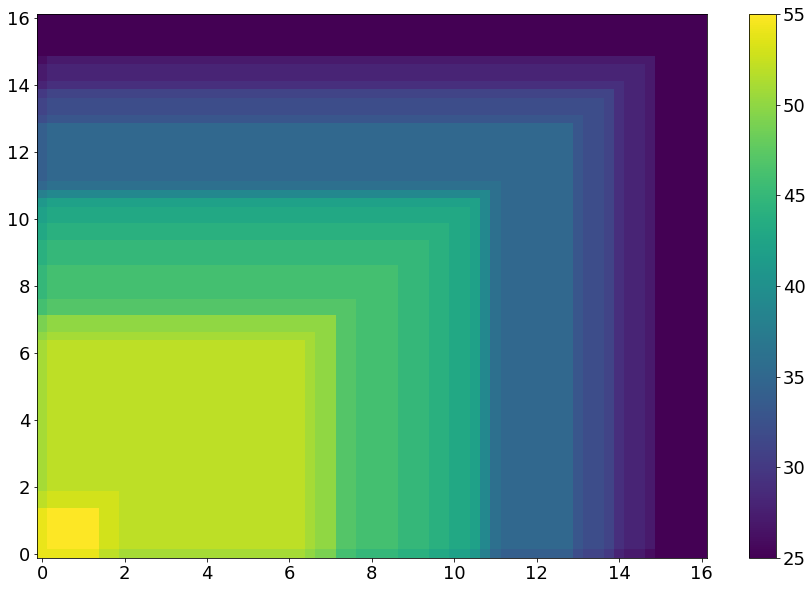

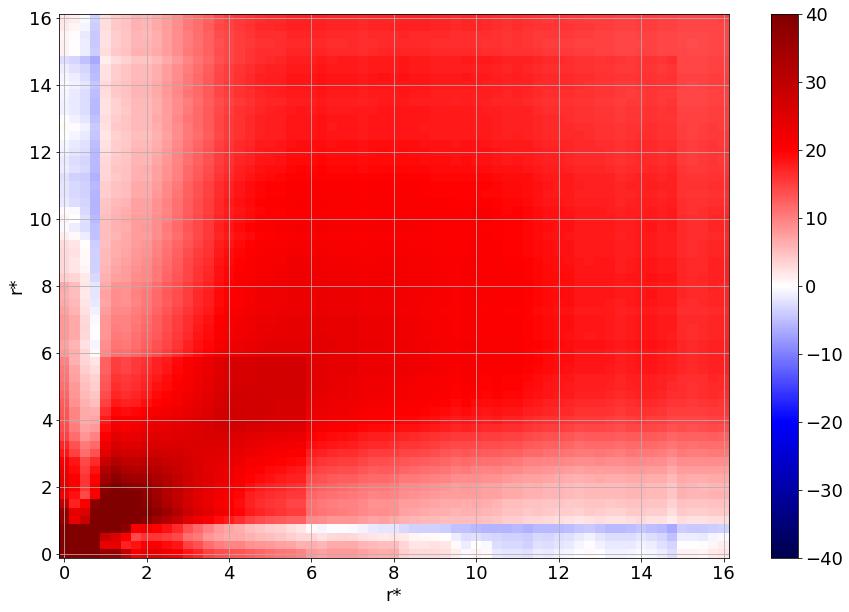

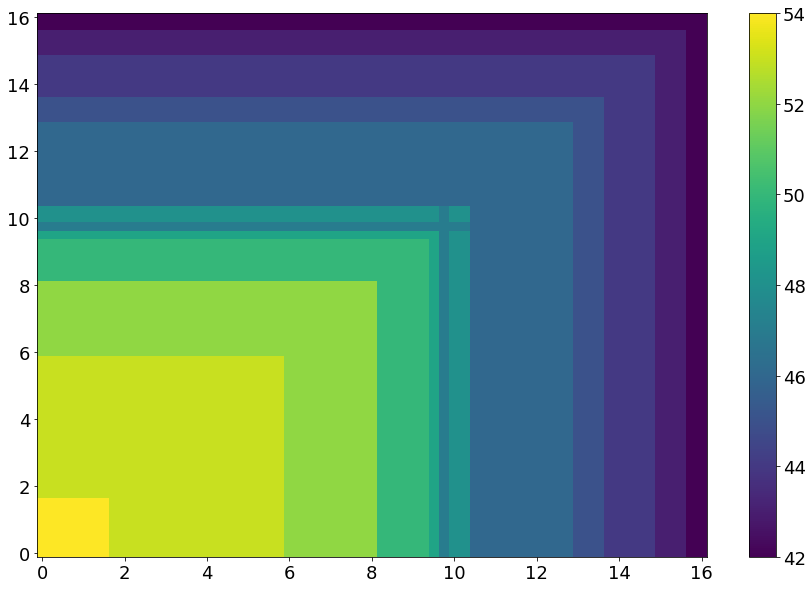

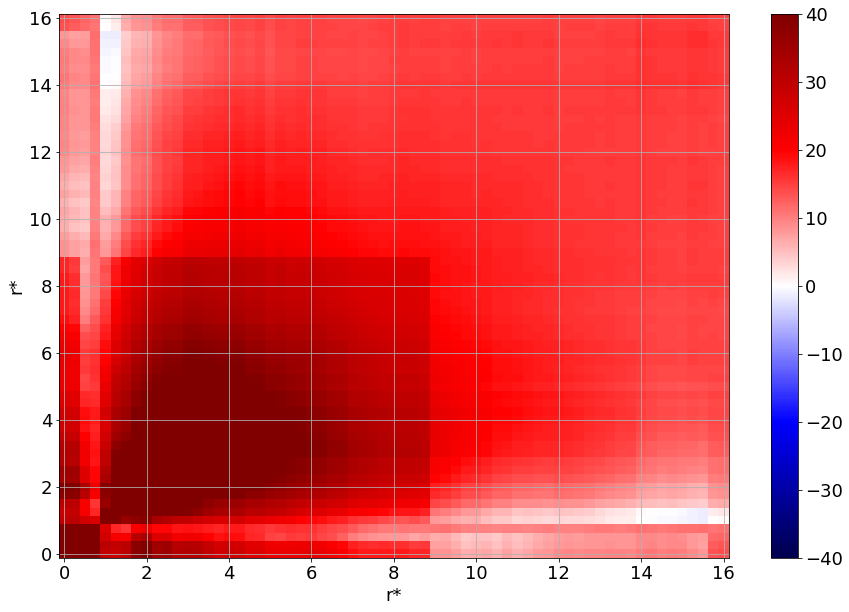

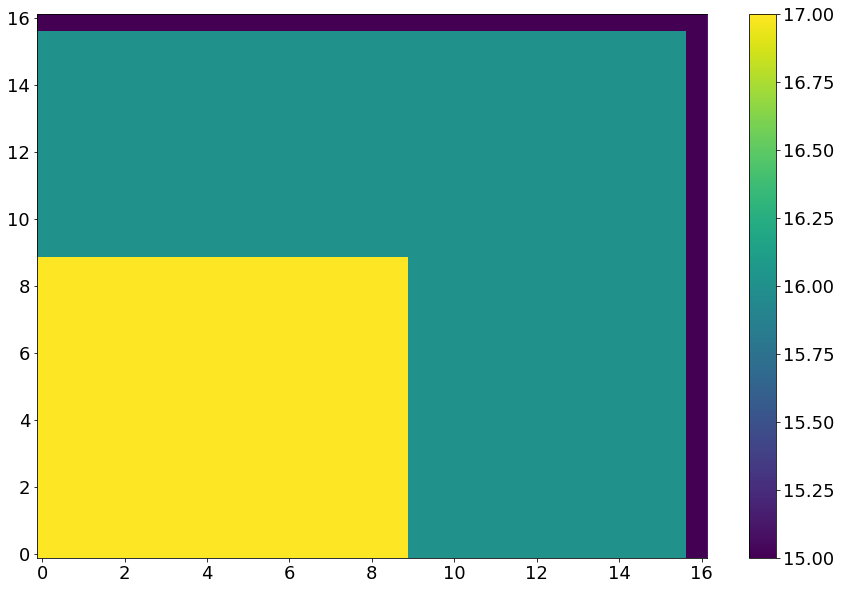

In [15]:
### COVARIANCE MATRIX IN POLAR COORDINATES BY CATEGORY

# Convert to 1D profile
ds_1D = ds_polar_all.mean('th', skipna=True)

COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_1D.groupby('cat'):
    COV_MAT_CAT[cat], product = du.covariance_matrix_1D(ds_cat, dim='r*')
    
    # Display covariance matrix
    plt.clf()
    norm = mpl.colors.TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)
    plt.pcolormesh(ds_1D['r*'], ds_1D['r*'], COV_MAT_CAT[cat], cmap='seismic', norm=norm);plt.colorbar();plt.grid()
    plt.xlabel('r*');plt.ylabel('r*')
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_orderBy_r'%cat)
    plt.show()
    
    # Display valid values
    product[~np.isnan(product)] = 1
    valid_values = np.nansum(product, axis=0)
    plt.pcolormesh(ds_1D['r*'], ds_1D['r*'], valid_values);plt.colorbar()
    if PARAMS['save_figs']: plt.savefig(save_dir + 'nb_of_valid_pixels_r_cat%i'%cat)
    plt.show()

Cat. 0 = 92


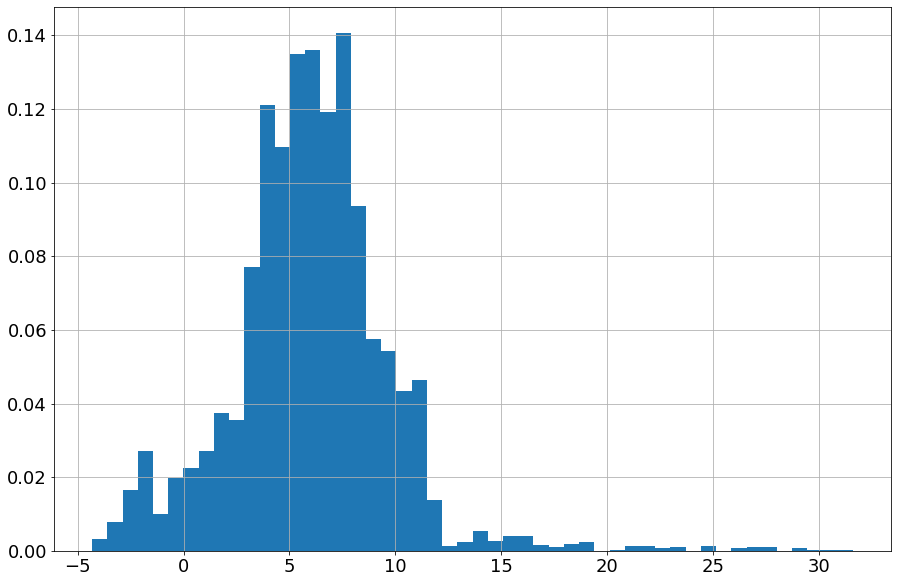

Cat. 1 = 82


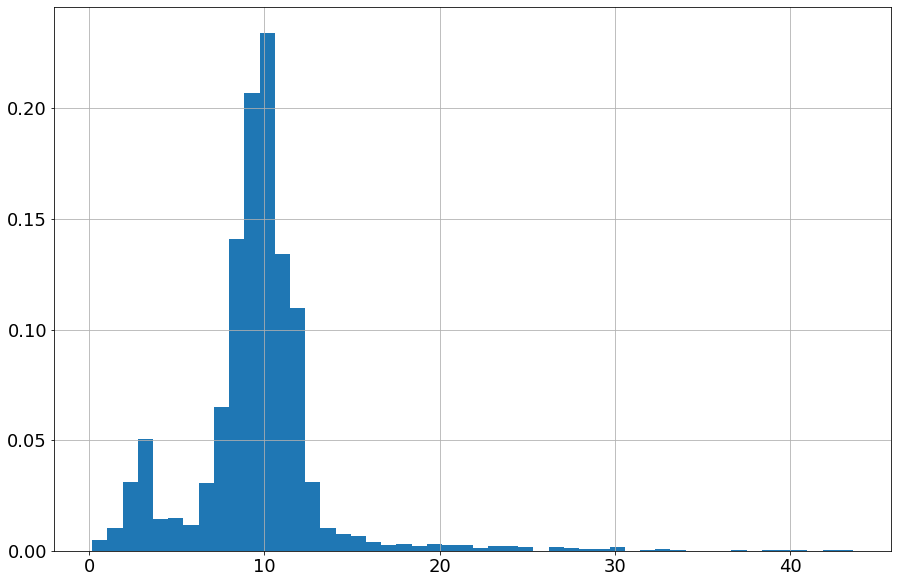

Cat. 2 = 41


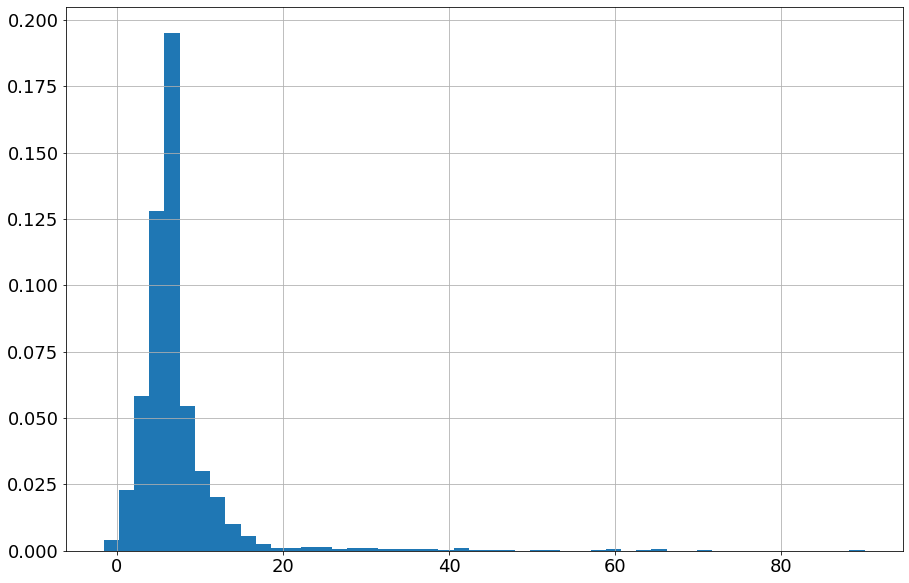

Cat. 3 = 55


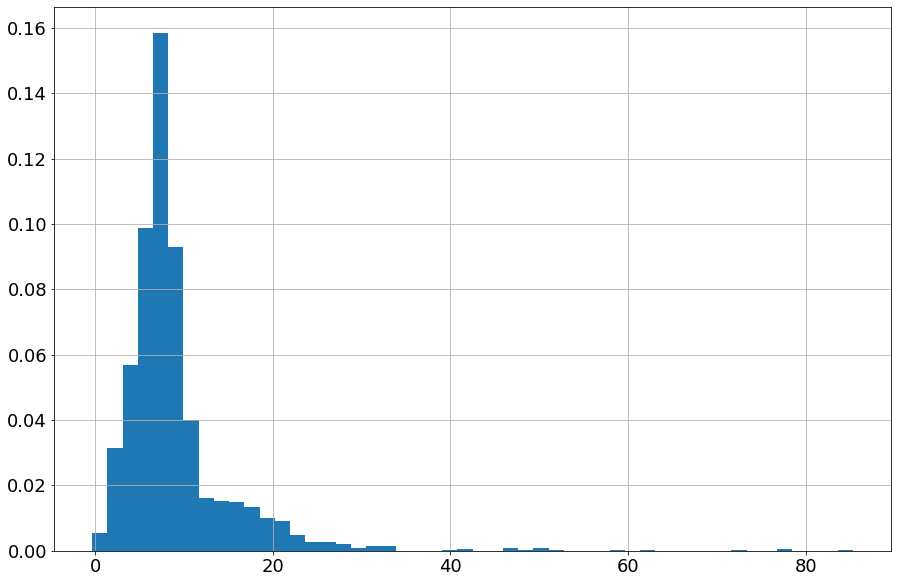

Cat. 4 = 54


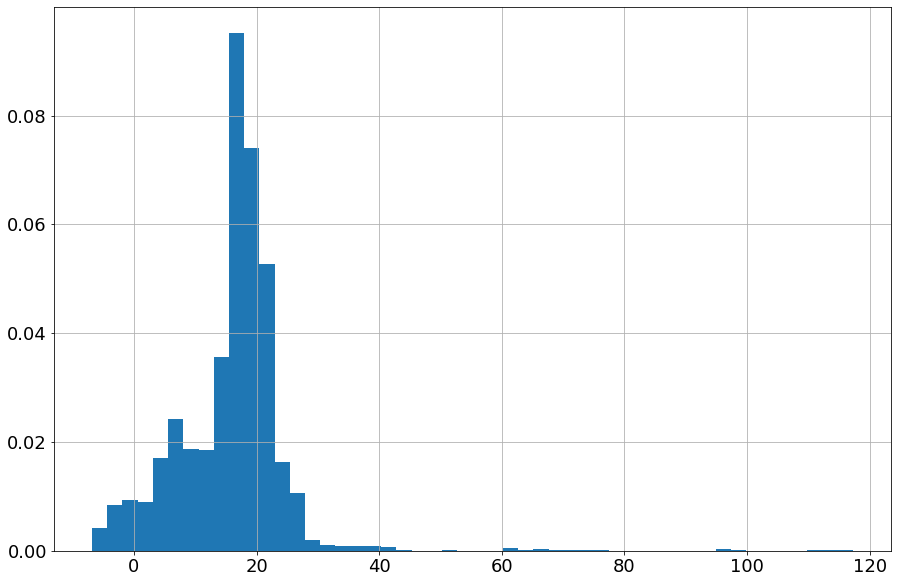

Cat. 5 = 17


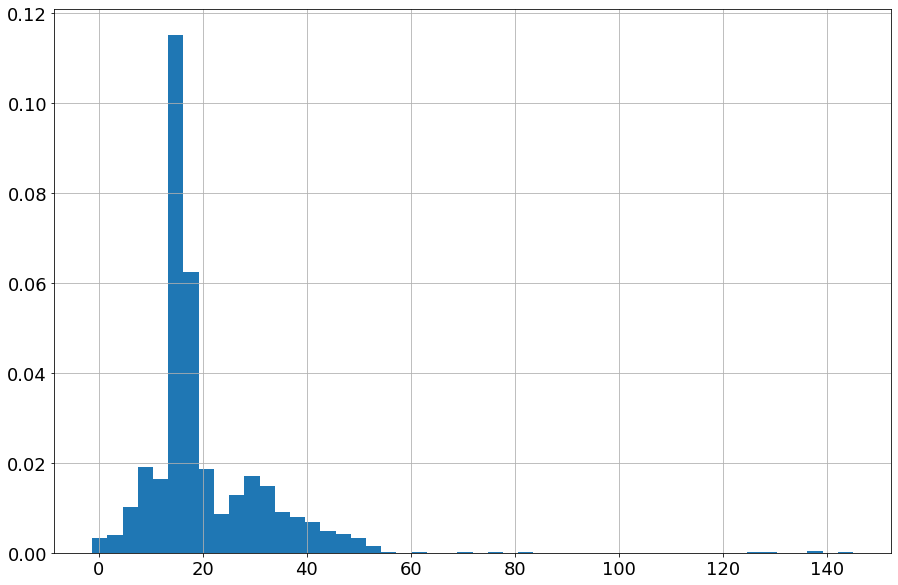

In [8]:
### HISTOGRAMS
for cat, ds_cat in ds_polar_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    plt.hist(COV_MAT_CAT[cat].flatten(), bins=50, density=True);plt.grid()
    plt.show()

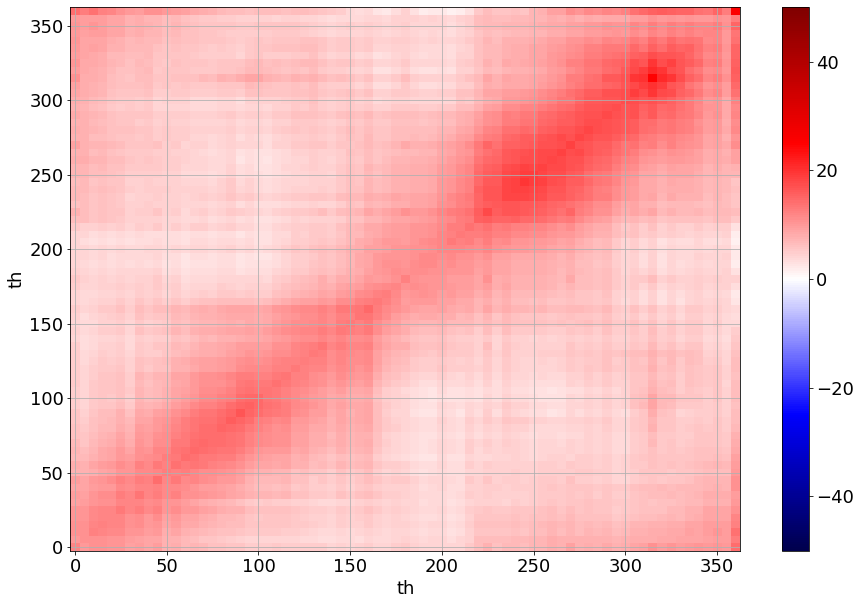

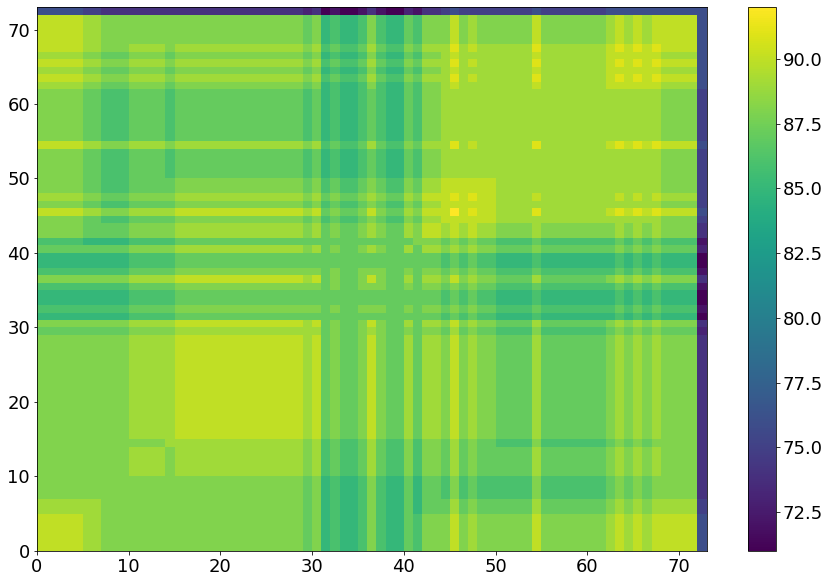

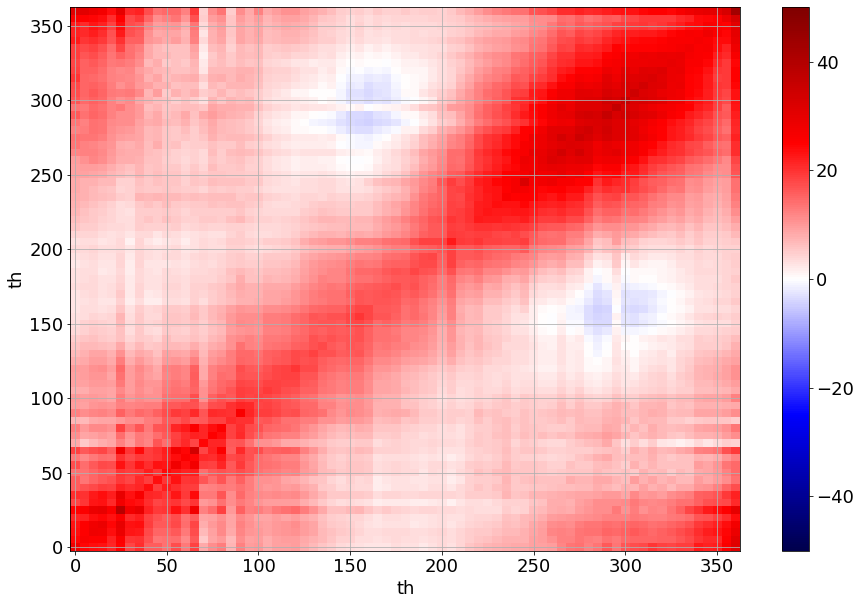

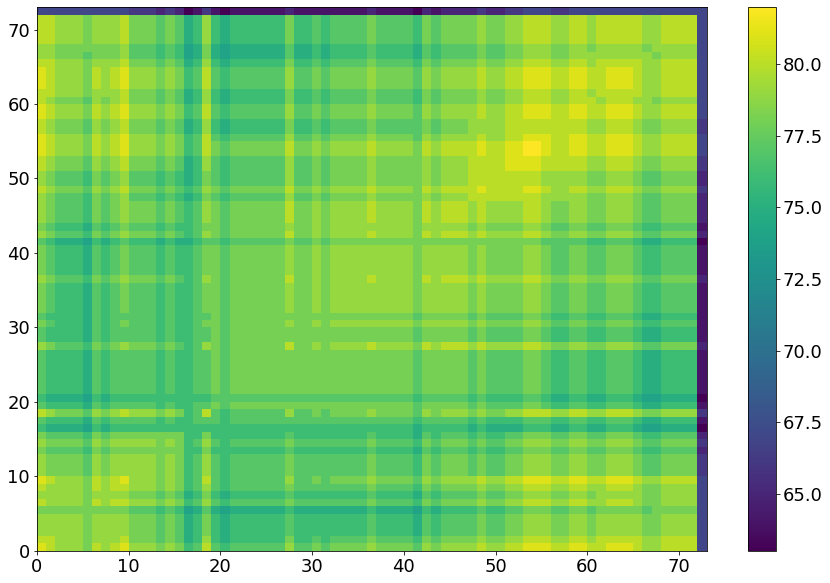

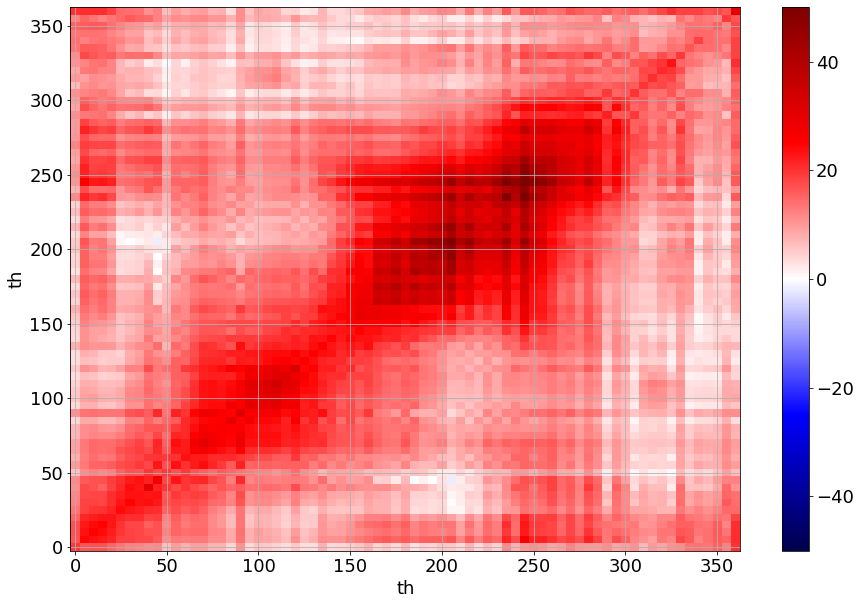

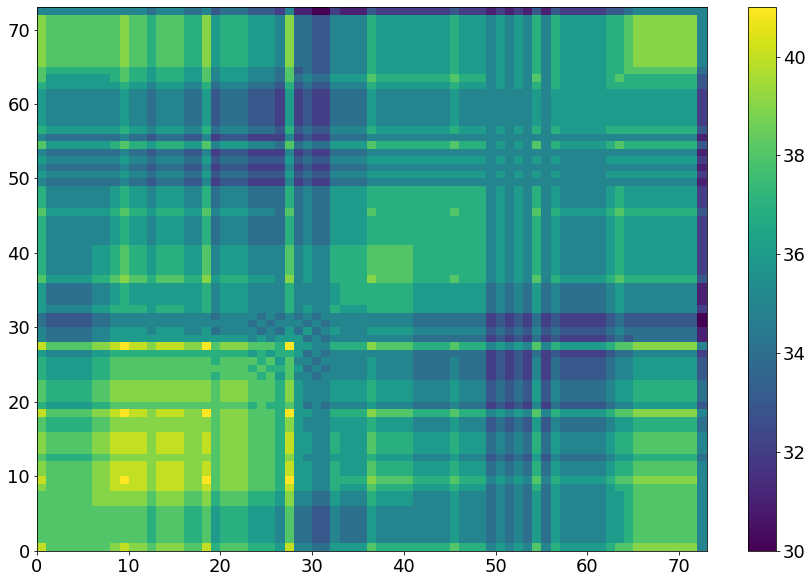

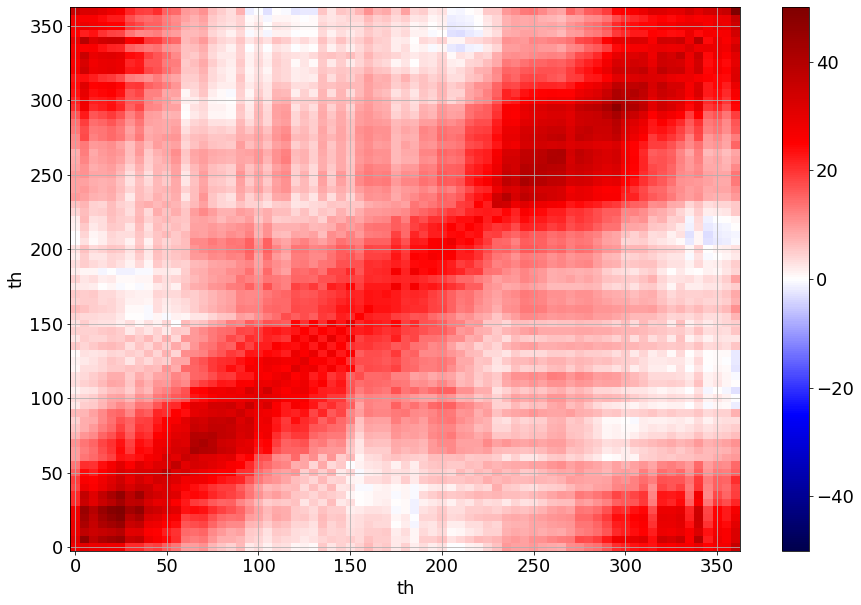

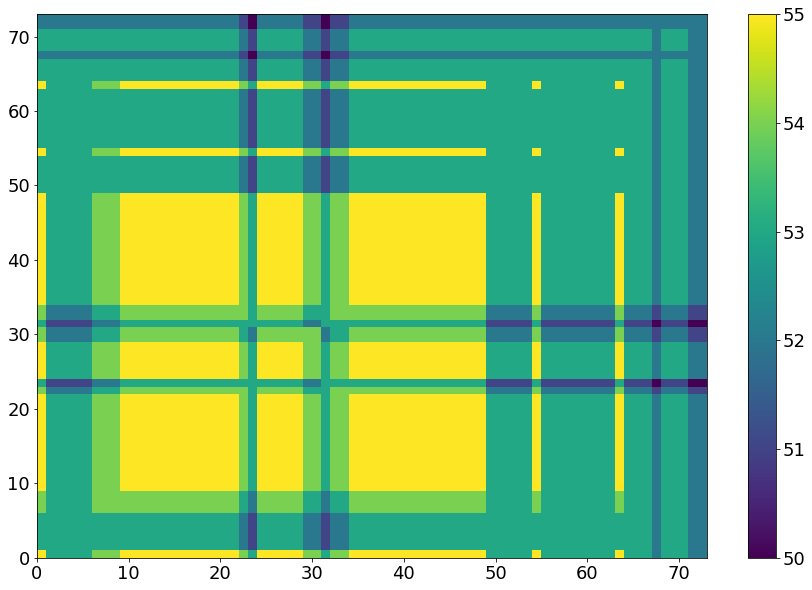

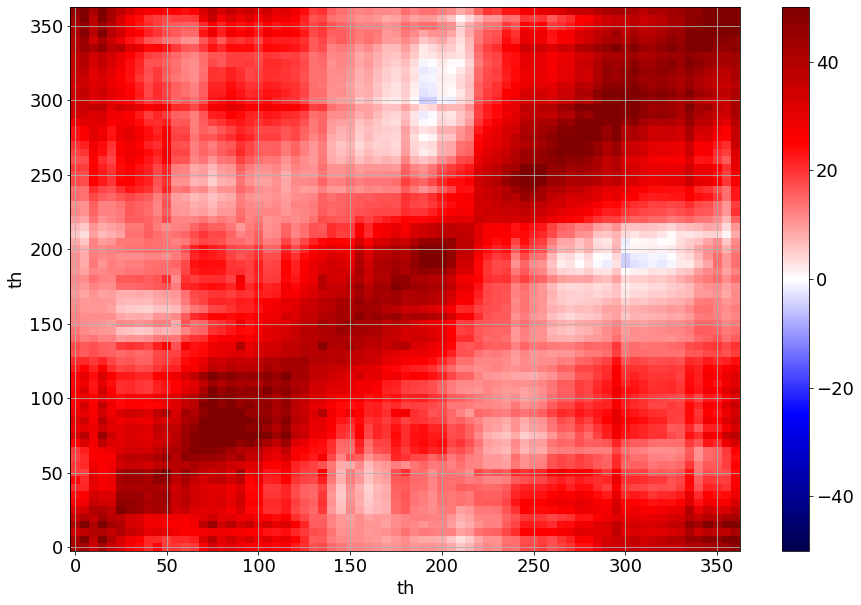

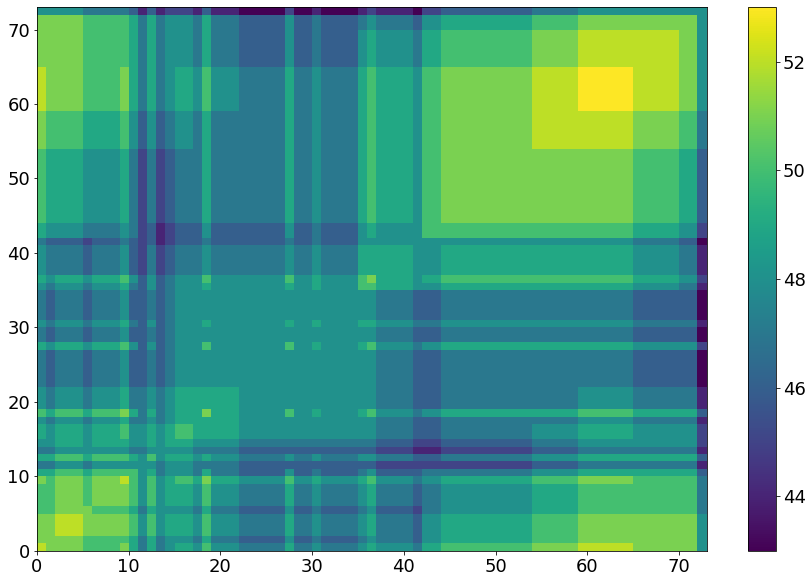

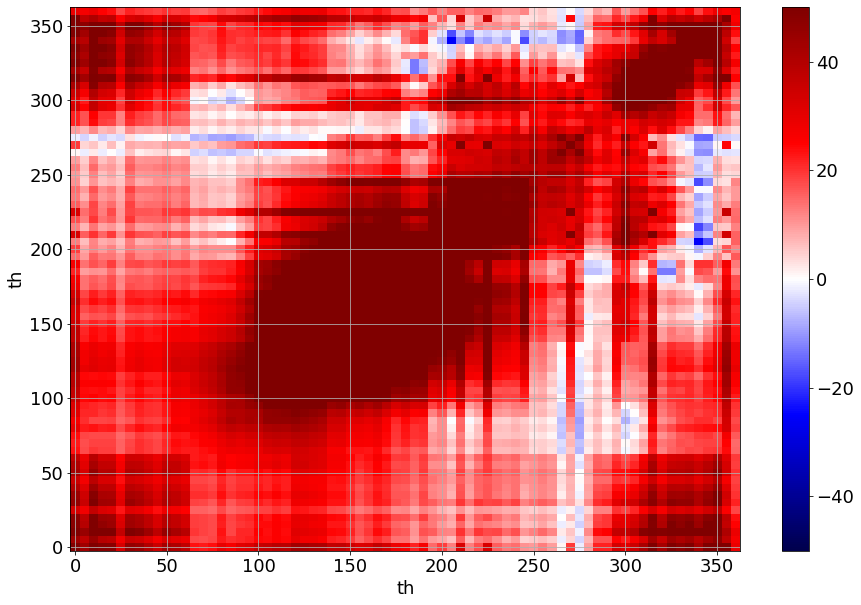

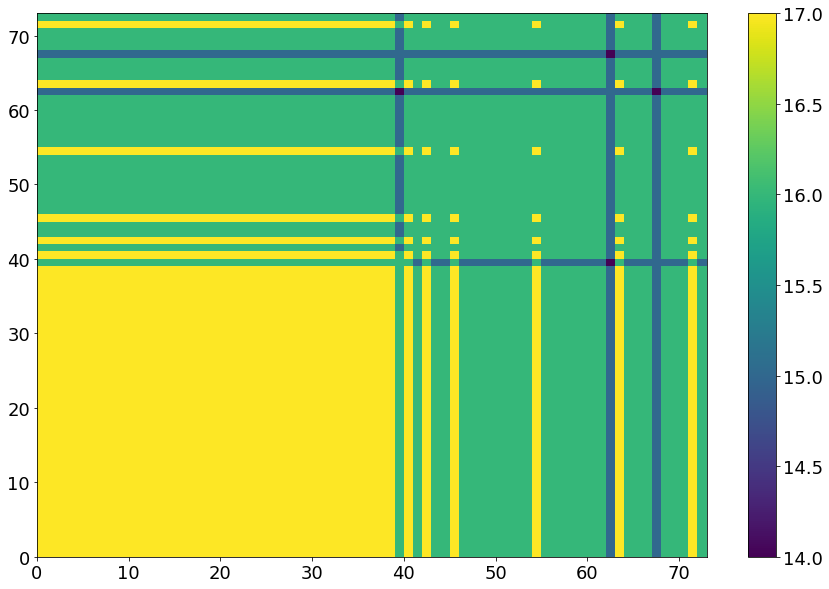

In [9]:
### ORDER BY THETA

# Convert to 1D profile
ds_1D = ds_polar_all.mean('r*', skipna=True)

COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_1D.groupby('cat'):
    COV_MAT_CAT[cat], product = du.covariance_matrix_1D(ds_cat, dim='th')
    
    plt.clf()
    plt.pcolormesh(ds_1D['th'], ds_1D['th'], COV_MAT_CAT[cat], cmap='seismic', vmin=-50, vmax=50);plt.colorbar();plt.grid()
    plt.xlabel('th');plt.ylabel('th')
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_orderBy_th'%cat)
    plt.show()
    
    # Display valid values
    product[~np.isnan(product)] = 1
    valid_values = np.nansum(product, axis=0)
    plt.pcolormesh(valid_values);plt.colorbar()
    if PARAMS['save_figs']: plt.savefig(save_dir + 'nb_of_valid_pixels_th_cat%i'%cat)
    plt.show()

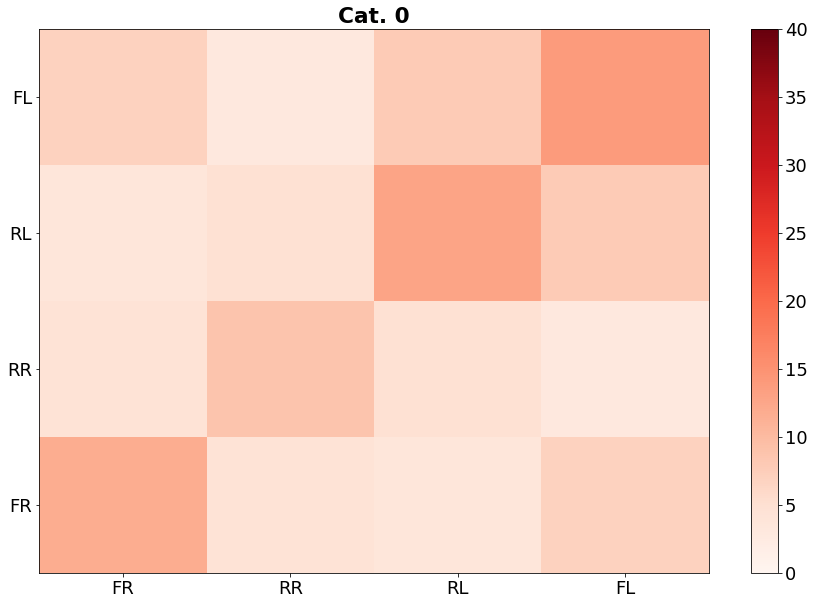

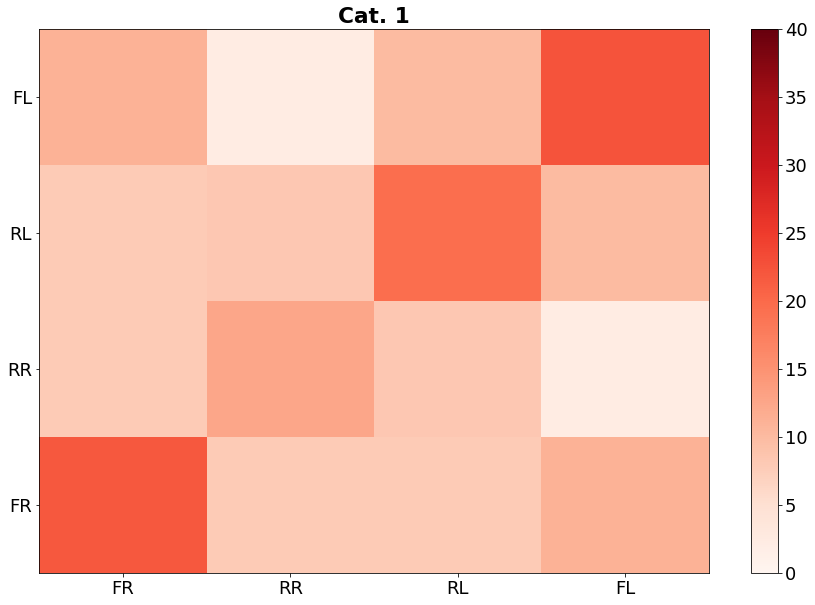

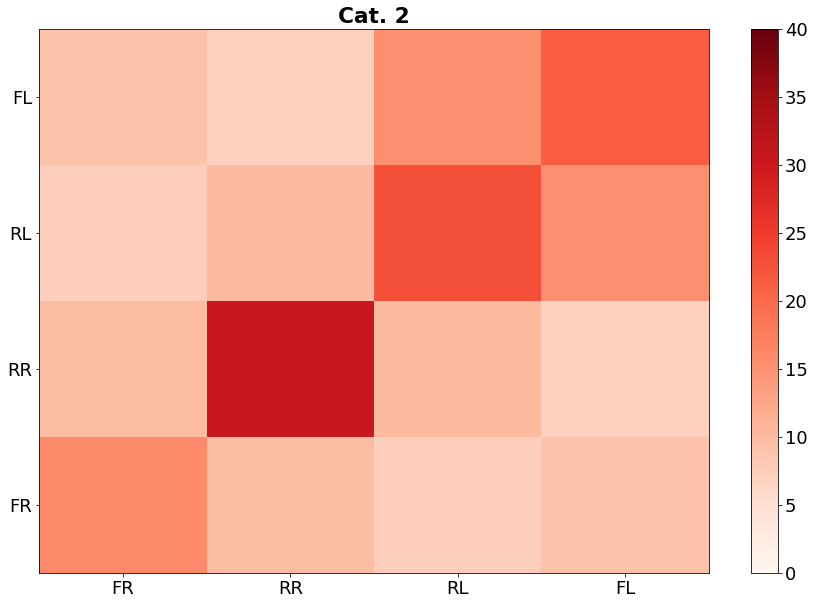

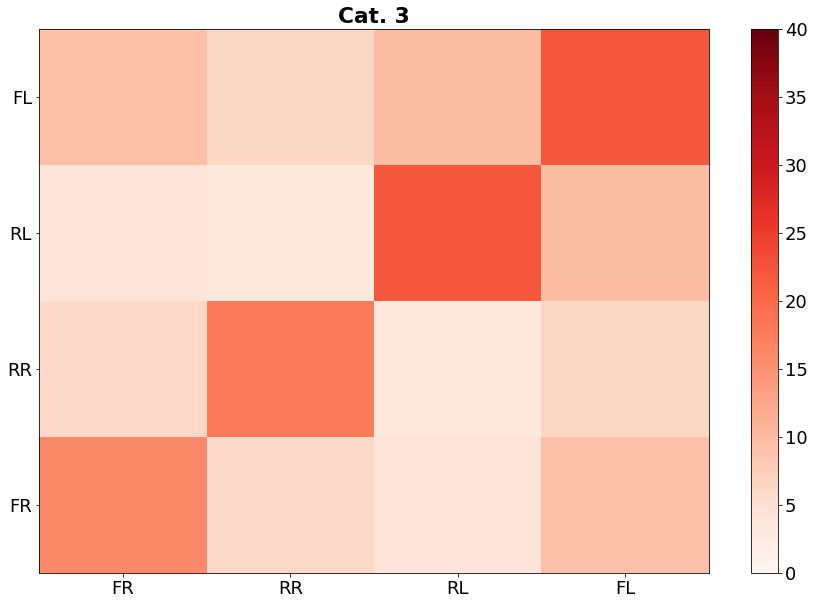

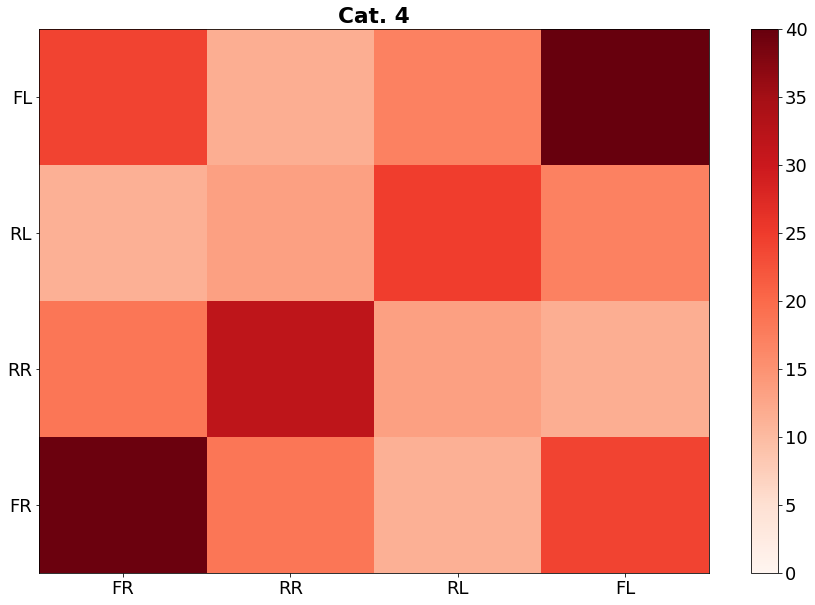

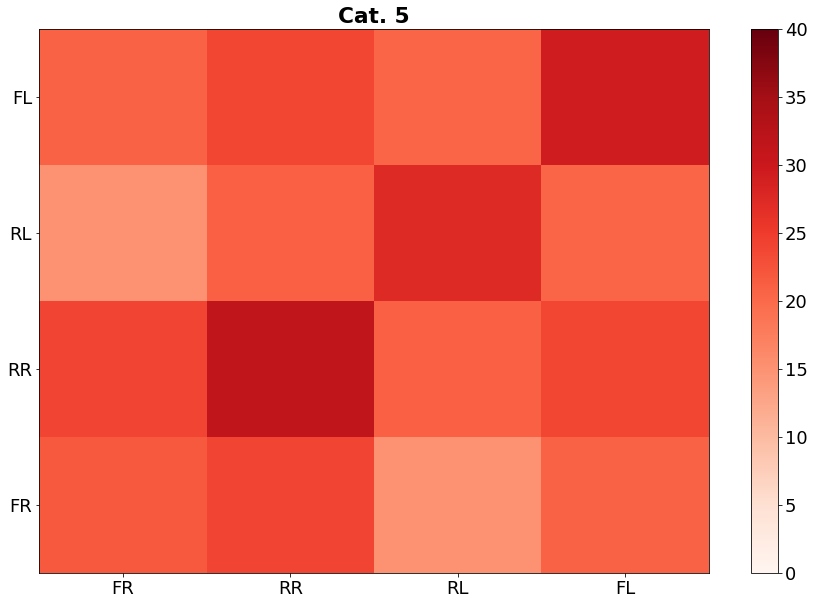

In [118]:
### COVARIANCE BETWEEN THETA QUADRANTS

# Define ds_QUAD
ds_FR = ds_polar_all.sel(th=slice(0, 90)).mean(dim='th', skipna=True).mean(dim='r*', skipna=True)
ds_FR = ds_FR.assign_coords(quadrant='FR').expand_dims('quadrant', axis=1)
ds_RR = ds_polar_all.sel(th=slice(90, 180)).mean(dim='th', skipna=True).mean(dim='r*', skipna=True)
ds_RR = ds_RR.assign_coords(quadrant='RR').expand_dims('quadrant', axis=1)
ds_RL = ds_polar_all.sel(th=slice(180, 270)).mean(dim='th', skipna=True).mean(dim='r*', skipna=True)
ds_RL = ds_RL.assign_coords(quadrant='RL').expand_dims('quadrant', axis=1)
ds_FL = ds_polar_all.sel(th=slice(270, 360)).mean(dim='th', skipna=True).mean(dim='r*', skipna=True)
ds_FL = ds_FL.assign_coords(quadrant='FL').expand_dims('quadrant', axis=1)
ds_QUAD = xr.concat((ds_FR, ds_RR, ds_RL, ds_FL), dim='quadrant')
# Remove dimension quadrant for category
ds_QUAD['cat'] = ds_QUAD['cat'].sel(quadrant='FR').drop('quadrant')

# Compute covariance matrices
COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_QUAD.groupby('cat'):
    COV_MAT_CAT[cat], product = du.covariance_matrix_1D(ds_cat, dim='quadrant')
    
    # Display covariance matrix
    plt.clf()
    plt.title('Cat. %i'%cat, weight='bold')
    ticks = list(np.arange(COV_MAT_CAT[cat].shape[0]) + 0.5)
    labels= list(ds_QUAD['quadrant'].values)
    plt.pcolormesh(COV_MAT_CAT[cat], cmap='Reds', vmin=0, vmax=40);plt.colorbar()
    plt.xticks(ticks, labels);plt.yticks(ticks, labels)
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_order_by_quadrant'%cat)
    plt.show()
    
    # Eventually plot histograms
    # plt.hist(COV_MAT_CAT[cat].flatten());plt.grid();plt.show()

In [146]:
ds_THETA['quadrant']

<xarray.DataArray 'quadrant' (quadrant: 24)>
array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150., 165.,
       180., 195., 210., 225., 240., 255., 270., 285., 300., 315., 330., 345.])
Coordinates:
  * quadrant  (quadrant) float64 0.0 15.0 30.0 45.0 ... 300.0 315.0 330.0 345.0

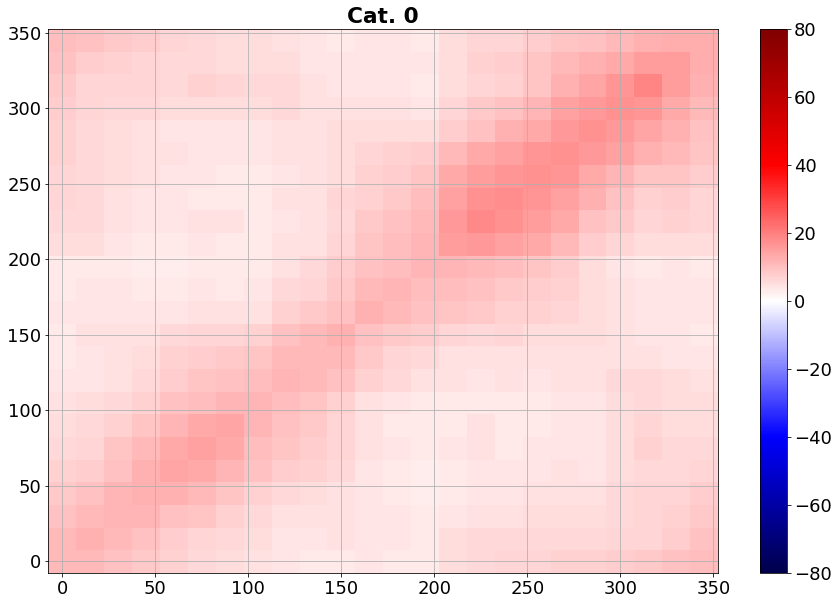

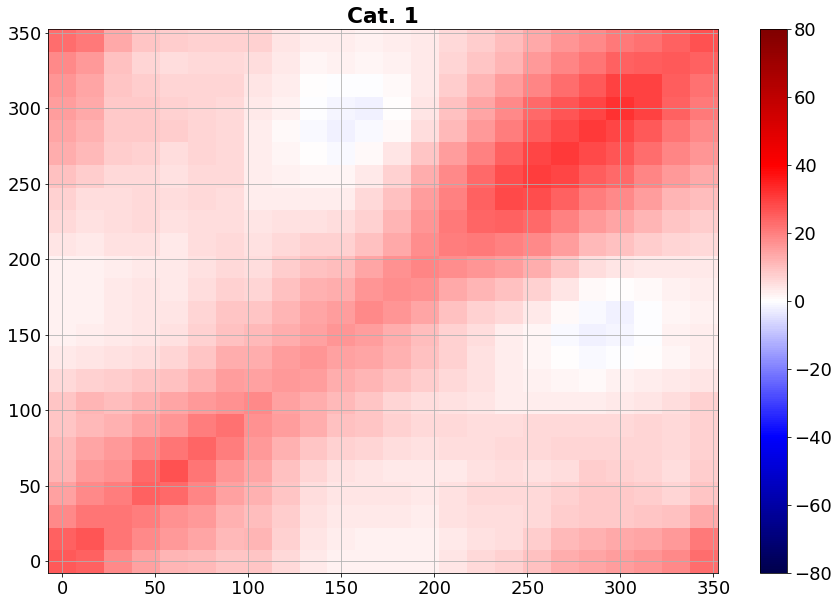

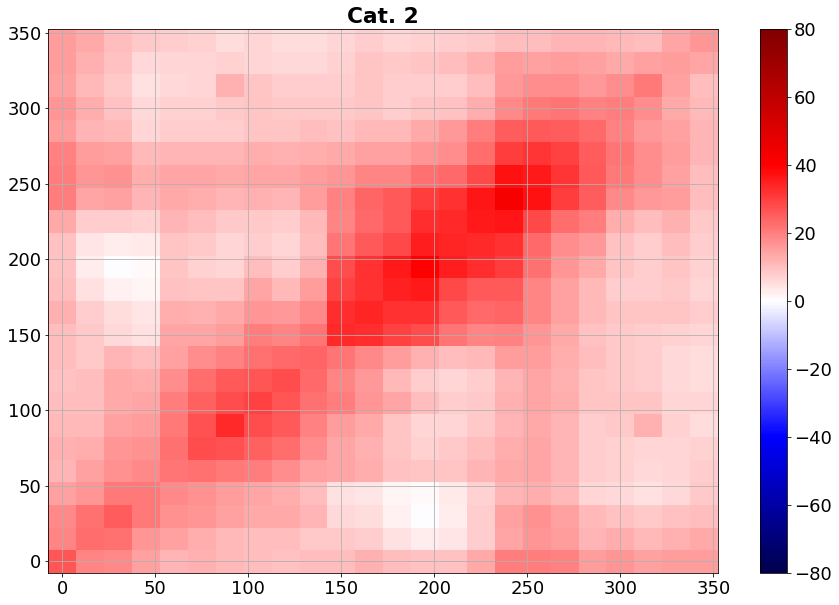

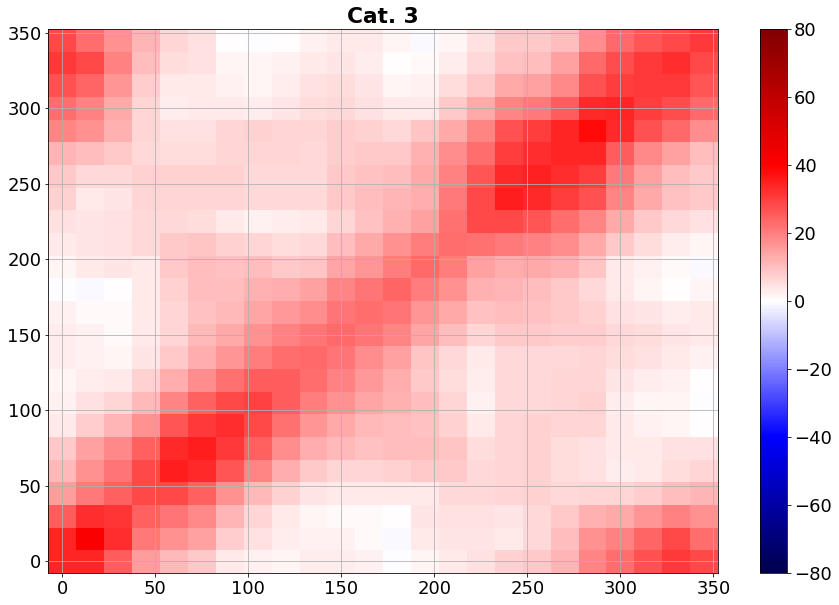

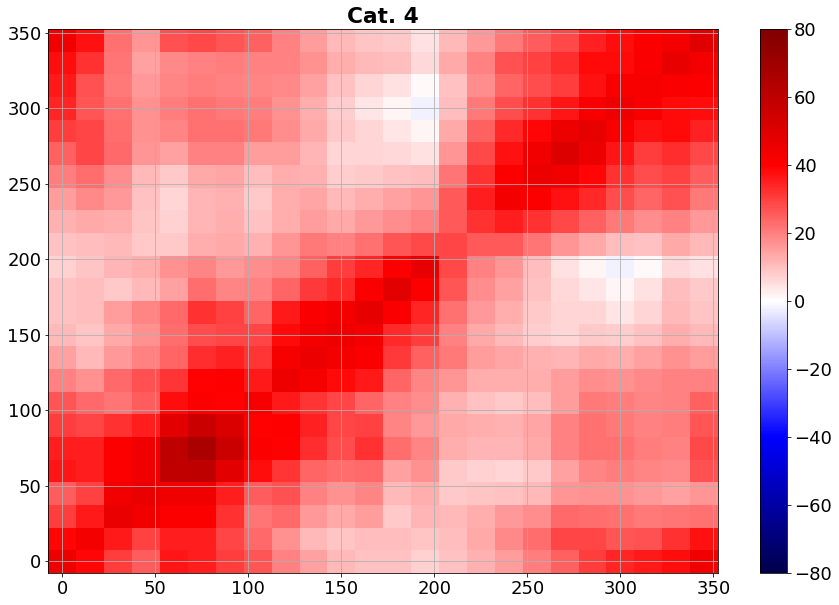

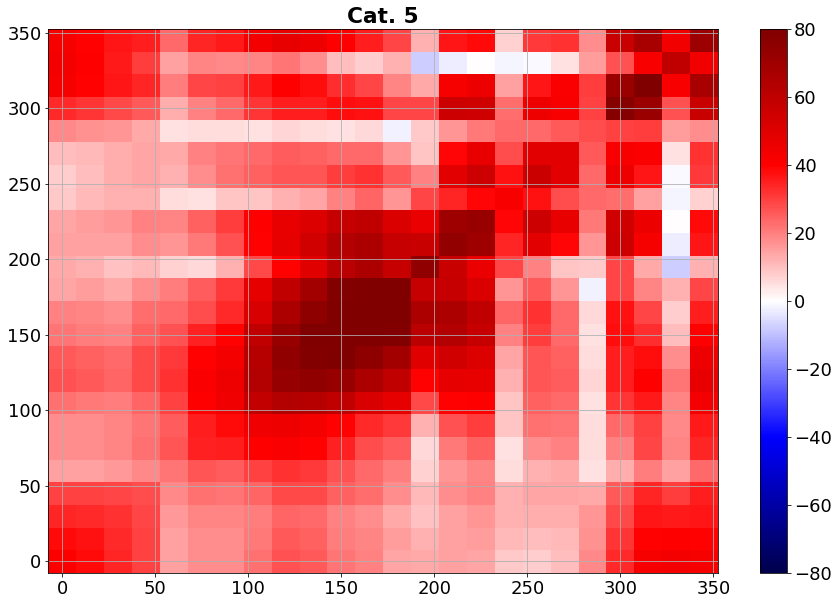

In [158]:
### GENERALIZATION OF THE ABOVE CODE

# Define ds_THETA
interval      = 15
th_intervals  = du.create_reference_axis(size=360, interval=interval)
list_of_ds_th = []
for th in th_intervals[:-1]:
    ds_current = ds_polar_all.sel(th=slice(th, th + interval)).mean(dim='th', skipna=True).mean(dim='r*', skipna=True)
    ds_current = ds_current.assign_coords(quadrant=th).expand_dims('quadrant', axis=1)
    list_of_ds_th.append(ds_current)
ds_THETA = xr.concat(list_of_ds_th, dim='quadrant')
ds_THETA['cat'] = ds_THETA['cat'].sel(quadrant=0).drop('quadrant')
ds_THETA

# Compute covariance matrices
COV_MAT_CAT = [None for i in range(6)]
for cat, ds_cat in ds_THETA.groupby('cat'):
    COV_MAT_CAT[cat], product = du.covariance_matrix_1D(ds_cat, dim='quadrant')
    
    # Display covariance matrix
    plt.clf()
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(ds_THETA['quadrant'], ds_THETA['quadrant'], COV_MAT_CAT[cat], cmap='seismic', vmin=-80, vmax=80);plt.colorbar();plt.grid()
    if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_order_by_quadrant'%cat)
    plt.show()
    
    # Eventually plot histograms
    # plt.hist(COV_MAT_CAT[cat].flatten());plt.grid();plt.show()

Cat. 0 = 92


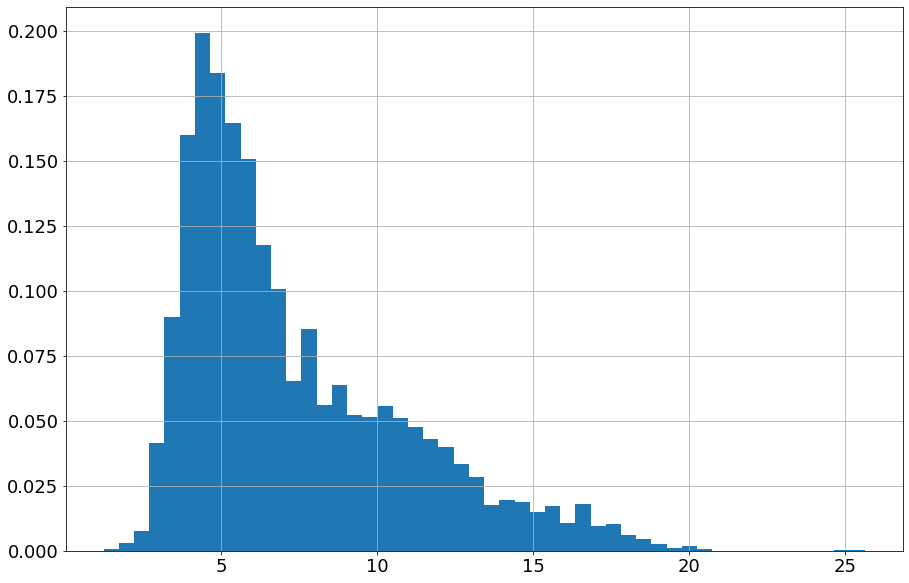

Cat. 1 = 82


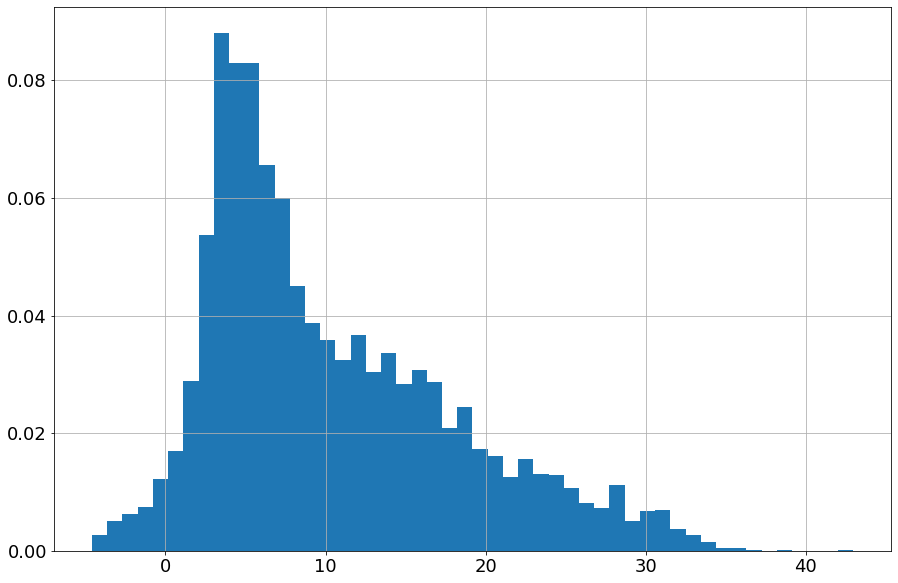

Cat. 2 = 41


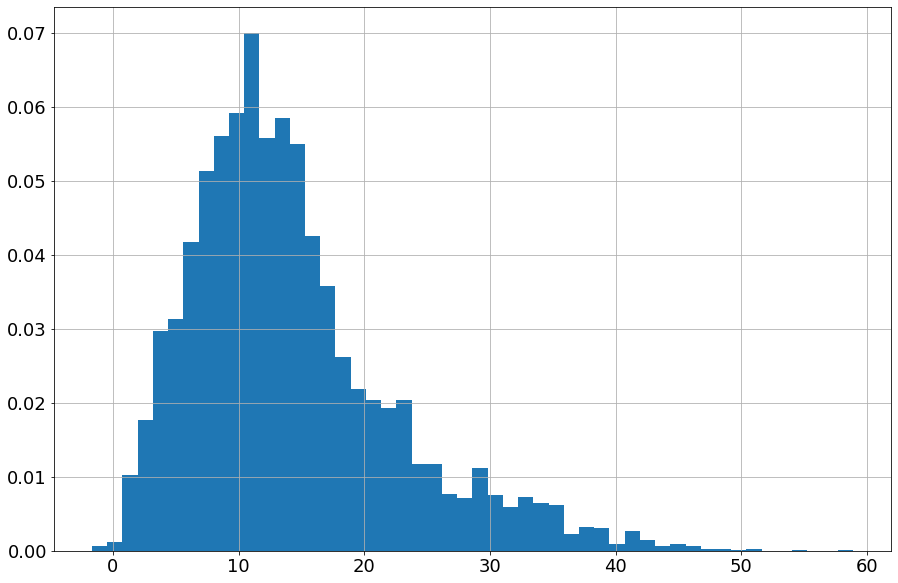

Cat. 3 = 55


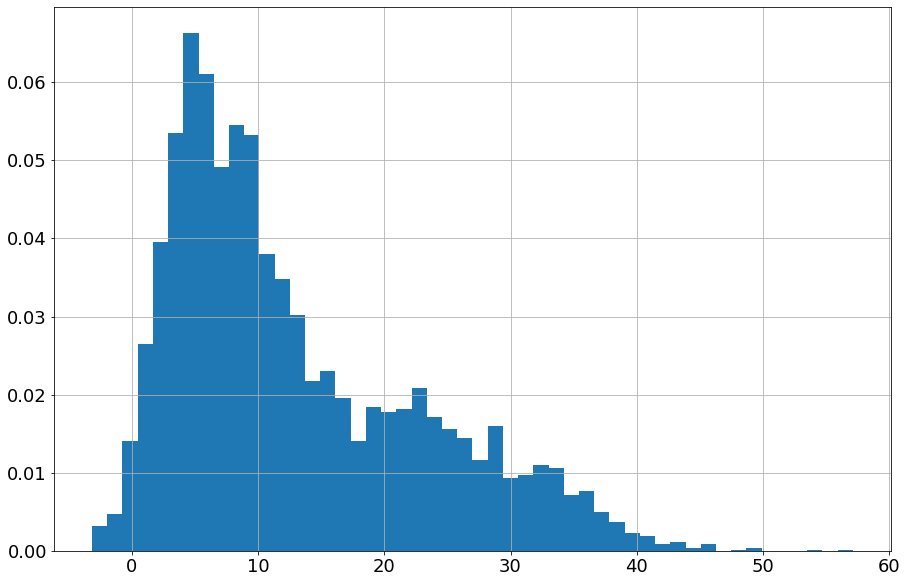

Cat. 4 = 54


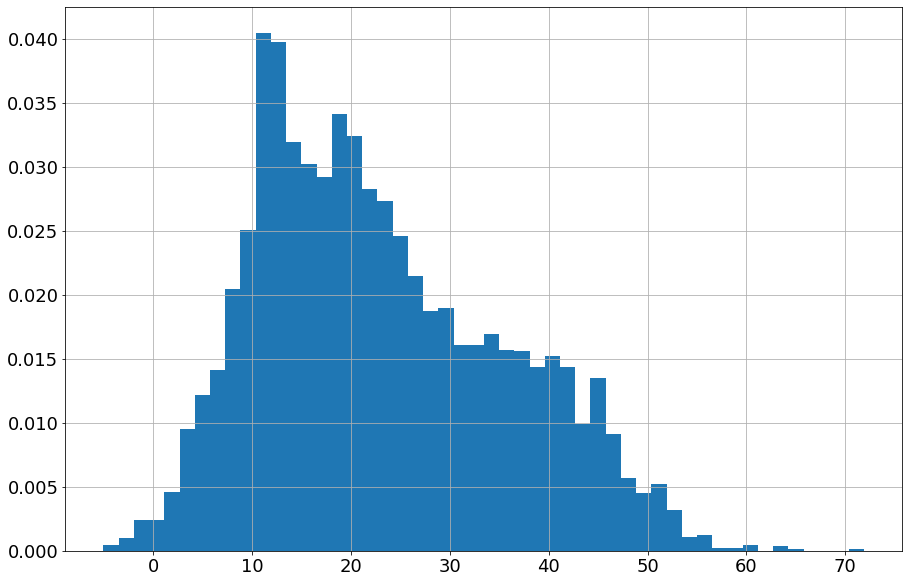

Cat. 5 = 17


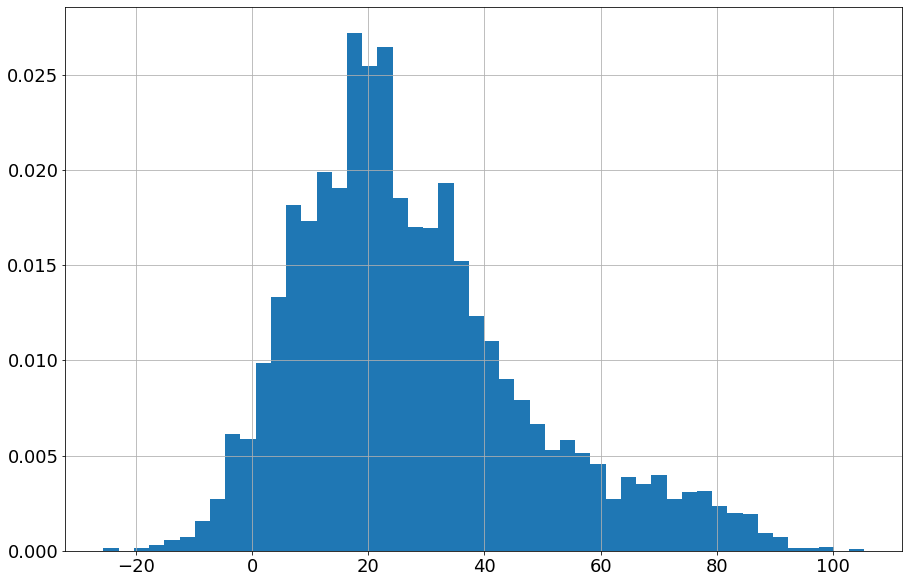

In [10]:
### HISTOGRAMS
for cat, ds_cat in ds_polar_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    plt.hist(COV_MAT_CAT[cat].flatten(), bins=50, density=True);plt.grid()
    plt.show()

[200.0, 500.0] =  109


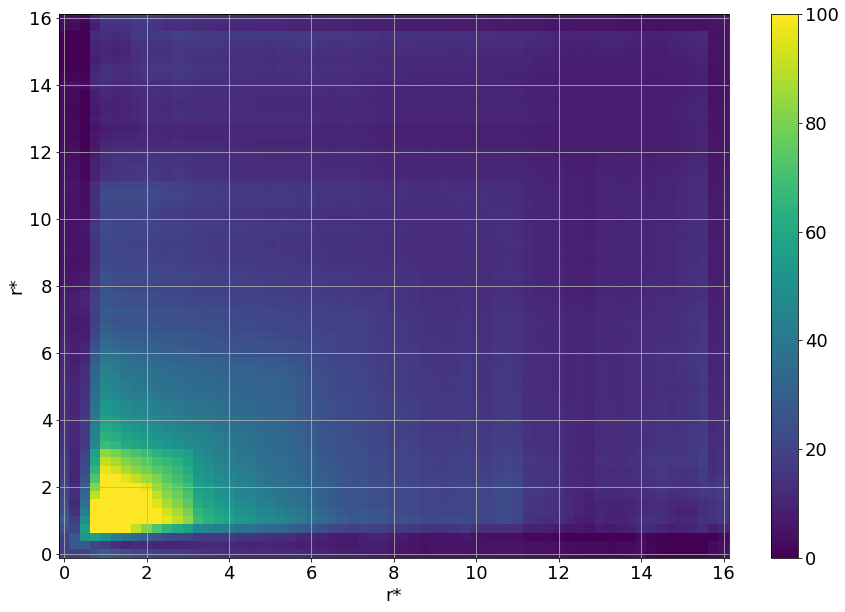

[150.0, 200.0] =  130


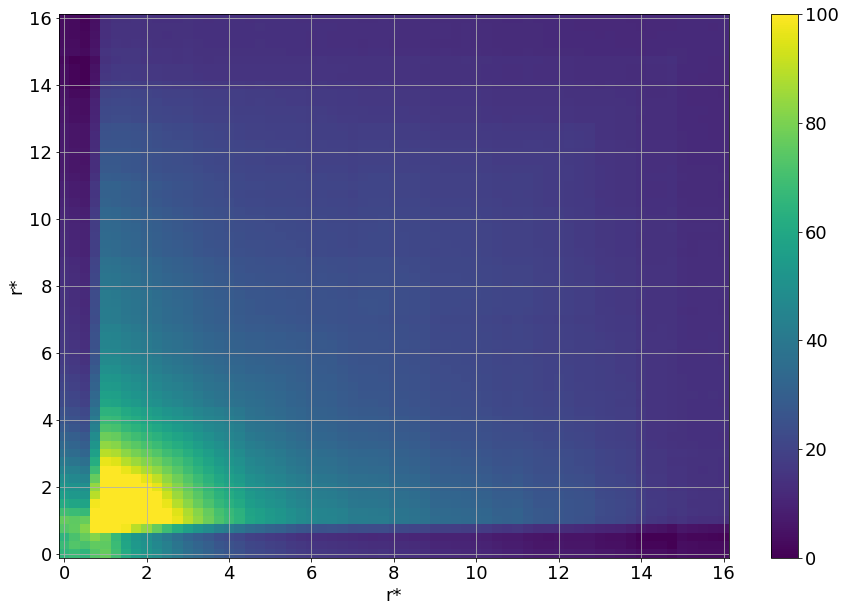

[0.0, 150.0] =  95


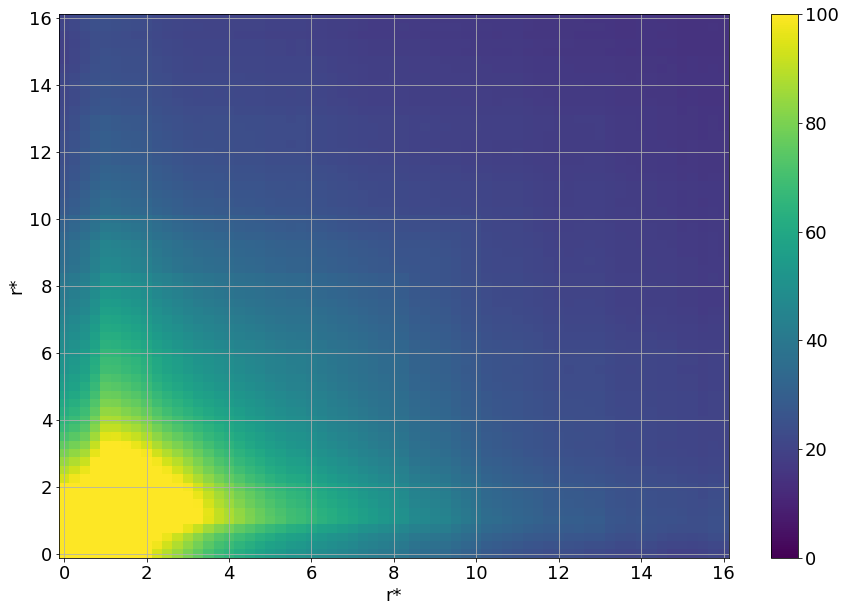

In [26]:
### COVARIANCE MATRIX BY CARAC LENGTH
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    f     = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter
    return f

# Compute carac length
bins         = [0, 150, 200, 500]
carac_length = np.sqrt(ds_polar_all['vmax'] * ds_polar_all['rmax'] / np.abs(coriolis(ds_polar_all['lat']))) / 1000. # km
ds_polar_all = ds_polar_all.assign({'carac_length': carac_length})
plt.hist(ds_polar_all['carac_length'], bins=bins)

# Convert to 1D
ds_1D = ds_polar_all.mean('th', skipna=True)

# Covariance by carac length
COV_MAT_CAT = {}
for length, ds_len in ds_1D.groupby_bins(carac_length, bins=bins):
    print('[{:.1f}, {:.1f}] = '.format(length.left, length.right), ds_len.dims['time'])
    
    key = str(int(length.mid))
    COV_MAT_CAT[key], product = du.covariance_matrix_1D(ds_len, dim='r*')
    
    # Display covariance matrix
    plt.clf()
    plt.pcolormesh(ds_1D['r*'], ds_1D['r*'], COV_MAT_CAT[key], cmap='viridis', vmin=0, vmax=100);plt.colorbar();plt.grid()
    plt.xlabel('r*');plt.ylabel('r*')
    # if PARAMS['save_figs']: plt.savefig(save_dir + 'cov_mat_cat%i_orderBy_r'%cat)
    plt.show()
    
    # Display valid values
    # product[~np.isnan(product)] = 1
    # valid_values = np.nansum(product, axis=0)
    # plt.pcolormesh(valid_values);plt.colorbar()
    # # if PARAMS['save_figs']: plt.savefig(save_dir + 'nb_of_valid_pixels_r_cat%i'%cat)
    # plt.show()

[200.0, 500.0] =  109
[150.0, 200.0] =  130
[0.0, 150.0] =  95


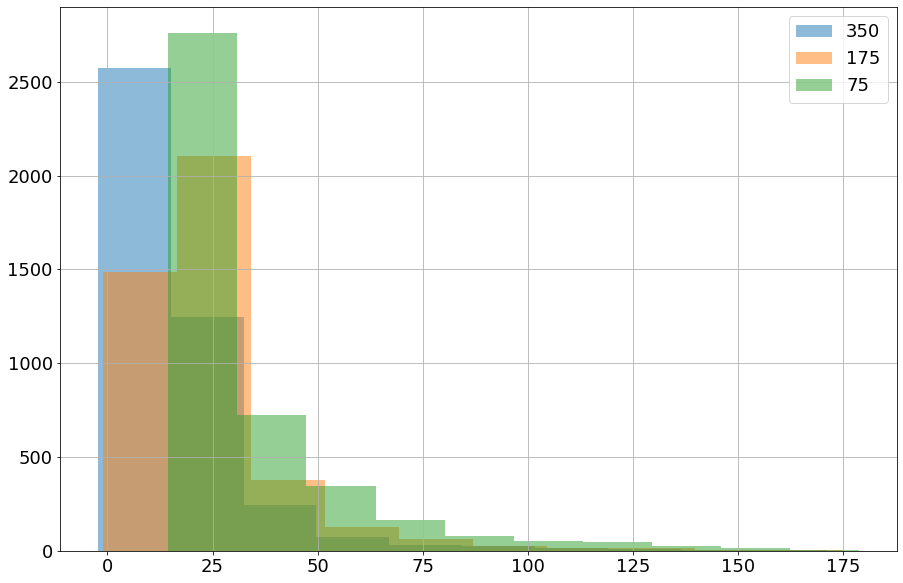

In [12]:
for length, ds_len in ds_1D.groupby_bins(carac_length, bins=bins):
    print('[{:.1f}, {:.1f}] = '.format(length.left, length.right), ds_len.dims['time'])
    
    key = str(int(length.mid))
    plt.hist(COV_MAT_CAT[key].flatten(), label=key, alpha=0.5, bins=10)
plt.grid();plt.legend()

(0.0, 5.0)

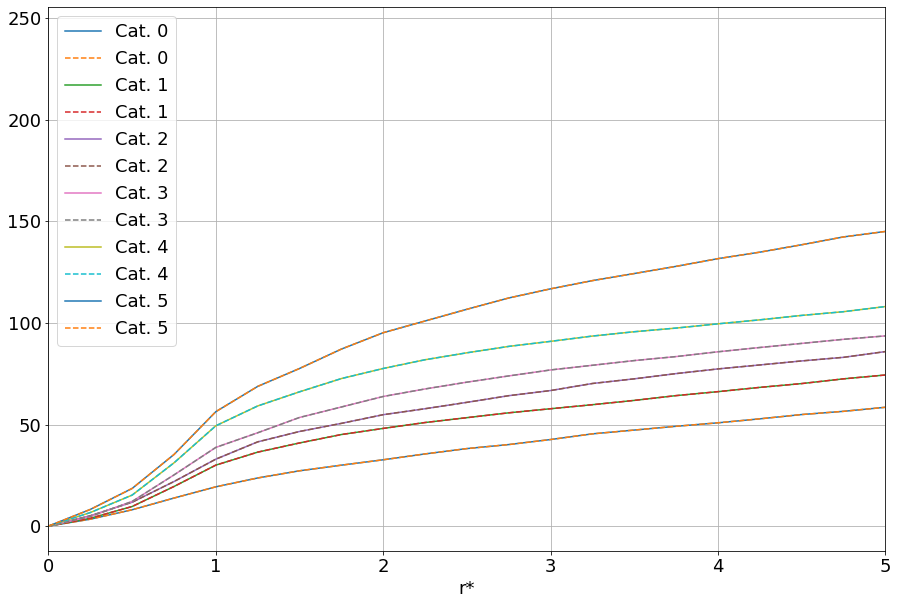

In [13]:
### TEST
for cat, ds_cat in ds_polar_all.groupby('cat'):  
    d     = ds_cat.mean('th', skipna=True).mean('time', skipna=True)
    M     = d['wind_speed'] * d['r*'] + 0.5 * coriolis(np.abs(d['lat'])) * d['r*'] ** 2
    M.plot(label='Cat. %i'%d['cat'])
    M_bis = d['wind_speed'] * d['r*'] # dominant term!!
    M_bis.plot(label='Cat. %i'%d['cat'], linestyle='dashed')
plt.grid();plt.legend();plt.xlim(0, 5)

447403.6209062238


NameError: name 'num_plots' is not defined

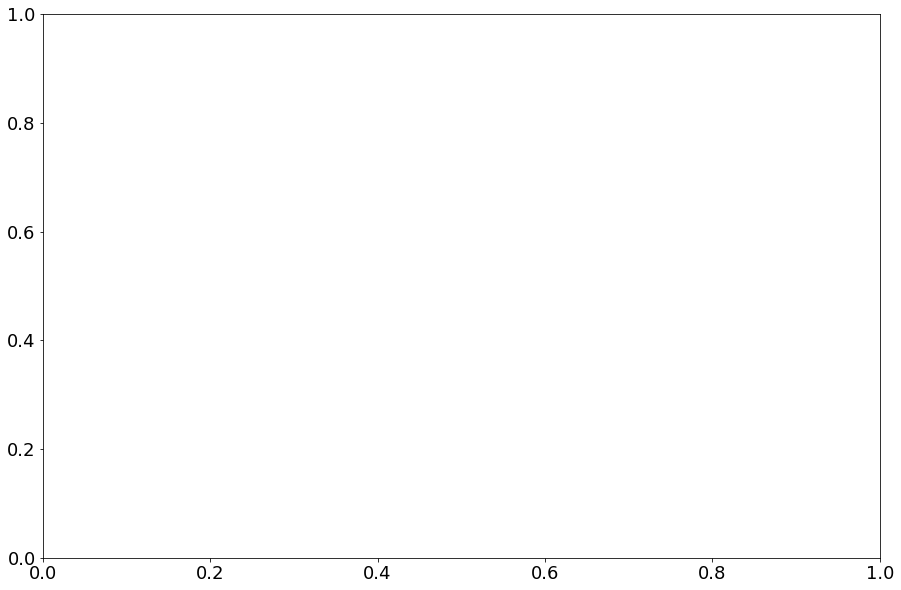

In [14]:
### TEST
for cat, ds_cat in ds_polar_all.groupby('cat'):  
    d = ds_cat.mean('th', skipna=True)

    # num_plots = len(d['time'])
    colormap  = plt.cm.coolwarm
    # colors    = [colormap(i) for i in np.linspace(0, 1,num_plots)]
    max_len   = np.nanmax(d['carac_length'])
    max_rmax  = np.nanmax(d['rmax'])
    print(max_rmax)

    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    for time_idx in range(len(d['time'])):
        current   = d.isel(time=time_idx)
        current['wind_speed']
        M_current = current['wind_speed'] * current['r*'] + 0.5 * coriolis(np.abs(current['lat'])) * current['r*'] ** 2
        # M_current.plot(color=colormap(current['carac_length'] / max_len), label=str(int(current['carac_length'])))
        M_current.plot(color=colormap(current['rmax'] / max_rmax))

    plt.grid();plt.xlim(0, 5); plt.ylim(0, 200)
    # plt.legend()
    plt.show()